In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import json
from PIL import Image, ImageDraw
from image_gen_aux import DepthPreprocessor
from diffusers import FluxControlPipeline, FluxPriorReduxPipeline, FluxFillPipeline, FluxPipeline
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from models.attention_processor import FluxAttnProcessor2_0_my
from utils import downsample_mask, mask_sym_attn

In [3]:
pipe_prior_redux = FluxPriorReduxPipeline.from_pretrained("black-forest-labs/FLUX.1-Redux-dev", torch_dtype=torch.bfloat16).to('cuda')

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model_id = "black-forest-labs/FLUX.1-dev"
pipe = FluxPipeline.from_pretrained(model_id, 
                                            text_encoder=None,
                                            text_encoder_2=None,
                                            torch_dtype=torch.bfloat16)
#pipe.enable_model_cpu_offload()
pipe.to('cuda')
pass

In [5]:
# paras
if 'dev' in model_id:
    kwargs = {
            'guidance_scale':2.5,
            'num_inference_steps':20,
        }
else:
    kwargs={
        'guidance_scale':0,
        'num_inference_steps':4
    }

In [6]:
name = 'Snipaste_2023-02-21_13-33-06'
with open(os.path.join('相似的几个2', f'{name}.json'), 'r') as f:
    data = json.load(f)
data.keys()

dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

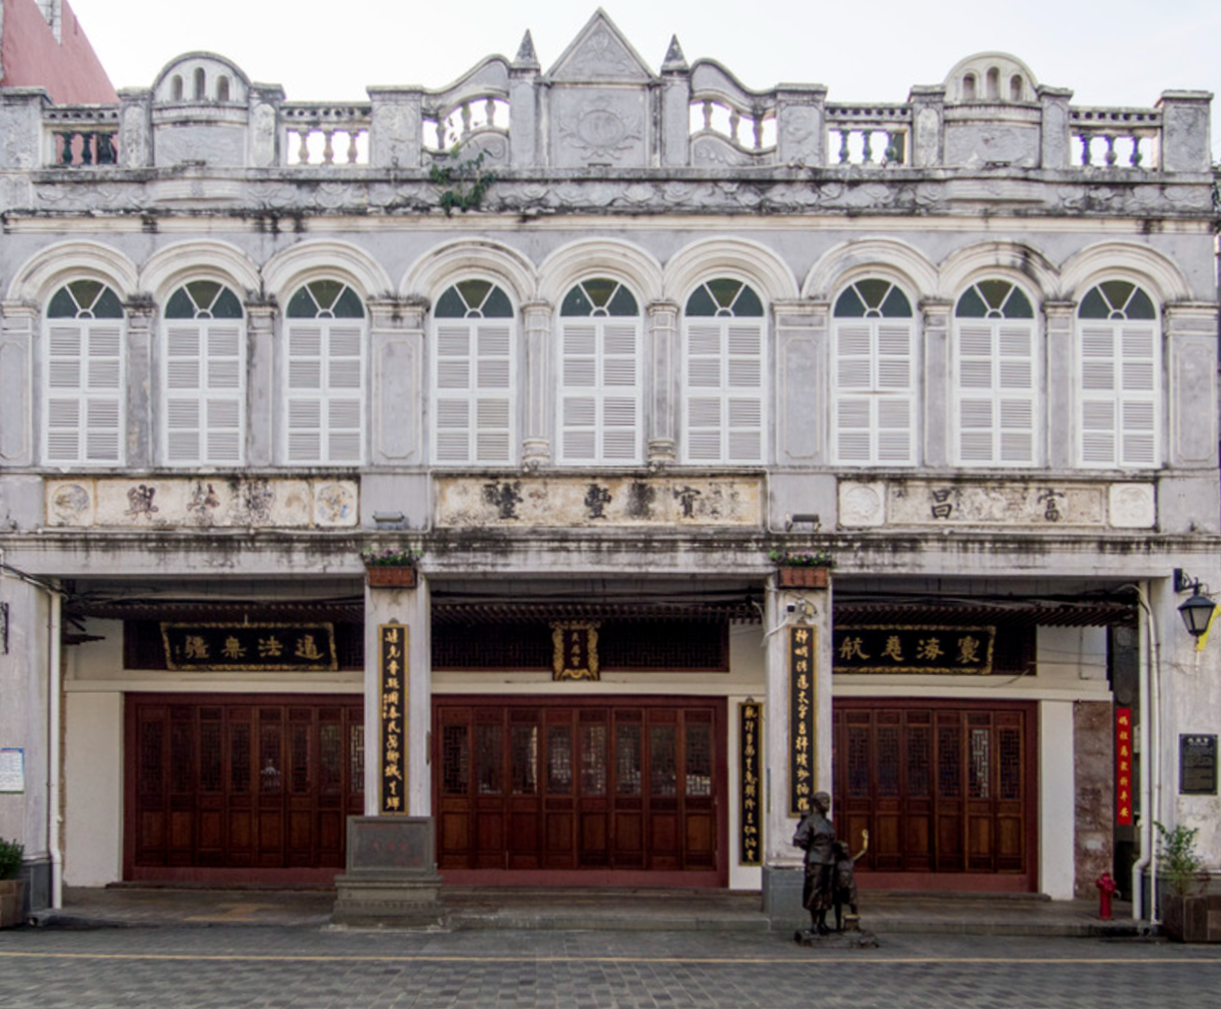

In [7]:
control_image = Image.open(os.path.join('相似的几个2', f'{name}.png')).convert('RGB')
control_image

In [8]:
sample = data['shapes'][20]
points = sample['points']
print(sample['label'])
points

window


[[1075.6492127481424, 303.745435076231],
 [1079.2685387153158, 295.9983845846907],
 [1087.011720705439, 286.69987080147115],
 [1094.33027459457, 281.0124550768392],
 [1103.8347803931813, 276.9161257773334],
 [1117.6271948279043, 275.15336703425794],
 [1132.928931411969, 277.65521555197773],
 [1144.2241642397196, 283.0505772336717],
 [1152.4201495704572, 291.8524131550527],
 [1158.1210266921255, 301.75535936920187],
 [1161.7262785909693, 312.75860215071714],
 [1160.4229615245024, 356.9511002094358],
 [1160.1215528999576, 467.35246151339334],
 [1073.0672391578264, 466.49424374290504],
 [1074.0924366756901, 352.3143189331476],
 [1074.0938862813496, 316.6541309989773]]

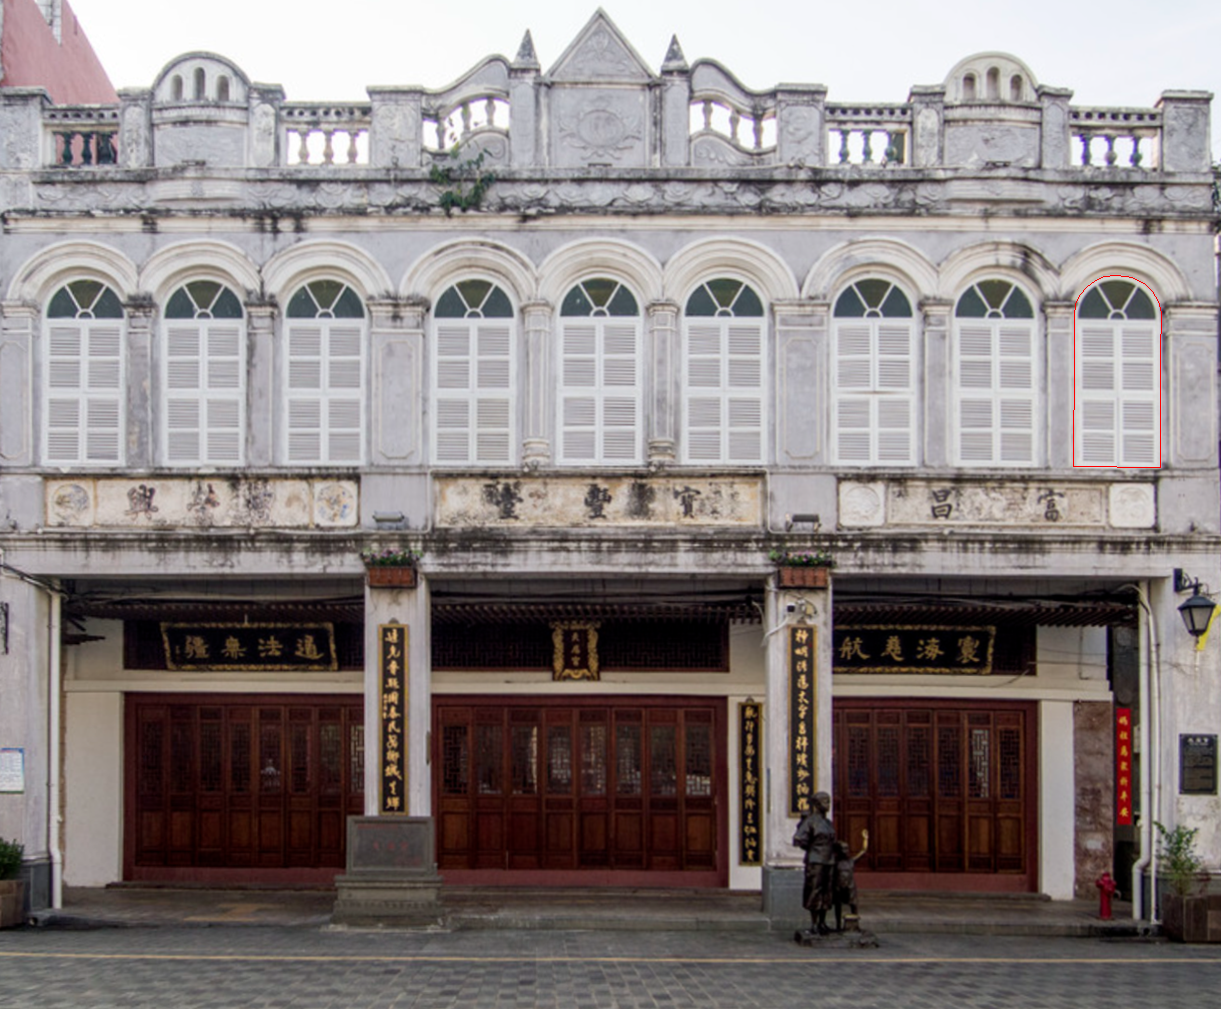

In [9]:
image_vis = control_image.copy()
draw = ImageDraw.Draw(image_vis)
polygon_points_int = [(int(point[0]), int(point[1])) for point in points]
draw.polygon(polygon_points_int, fill=None, outline=(255, 0, 0))
image_vis

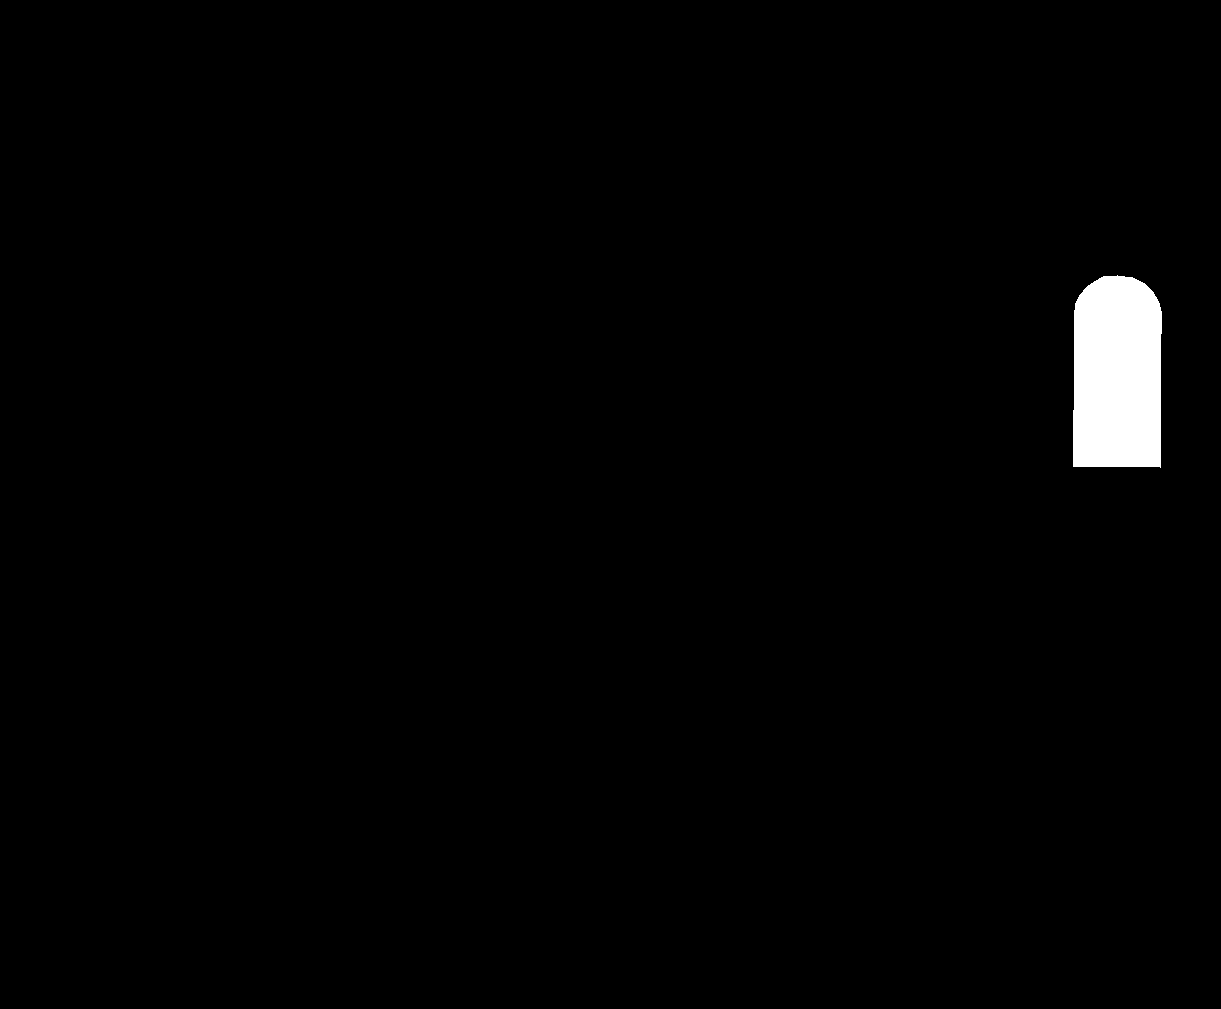

In [10]:
mask_image = Image.new('L', (control_image.width, control_image.height), 0)
draw = ImageDraw.Draw(mask_image)
polygon_points_int = [(int(point[0]), int(point[1])) for point in points]
draw.polygon(polygon_points_int, fill=255)
mask_image

In [11]:
name2 = 'Snipaste_2023-02-21_13-33-51'
with open(os.path.join('相似的几个2', f'{name2}.json'), 'r') as f:
    data2 = json.load(f)

window


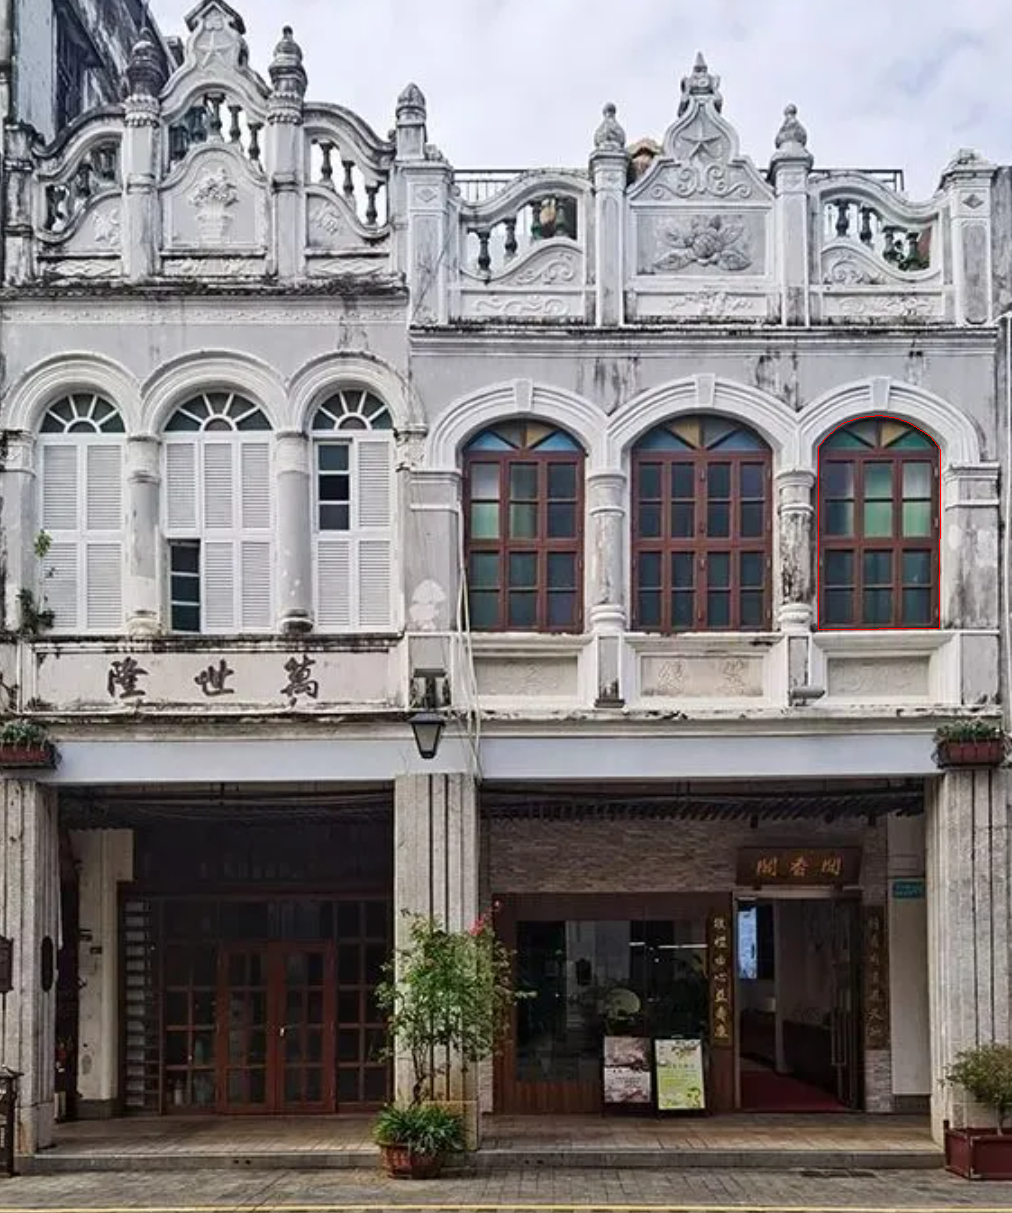

In [12]:
control_image2 = Image.open(os.path.join('相似的几个2', f'{name2}.png')).convert('RGB')
sample = data2['shapes'][17]
points = sample['points']
print(sample['label'])
image_vis = control_image2.copy()
draw = ImageDraw.Draw(image_vis)
polygon_points_int = [(int(point[0]), int(point[1])) for point in points]
draw.polygon(polygon_points_int, fill=None, outline=(255, 0, 0))
image_vis

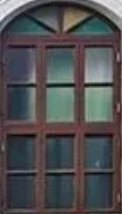

In [39]:
x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]

# 找到最小和最大值
min_x = min(x_coords)
max_x = max(x_coords)
min_y = min(y_coords)
max_y = max(y_coords)

# 输出结果
box = (min_x, min_y, max_x, max_y)
style_image = control_image2.crop(box)
style_image

In [40]:
def encode_batch_imgs(imgs):
    pipe_prior_output = None
    for img in imgs:
        dic = pipe_prior_redux(img)
        if pipe_prior_output == None:
            pipe_prior_output = dic
        else:
            for k,v in pipe_prior_output.items():
                pipe_prior_output[k] = torch.cat([v, dic[k]], dim=0)
    return pipe_prior_output
pipe_prior_output = encode_batch_imgs([control_image, style_image])
pipe_prior_output['prompt_embeds'].shape

torch.Size([2, 1241, 4096])

In [41]:
num_img_tokens = (control_image.height // 16) * (control_image.width // 16)
mask_downsample = downsample_mask(torch.from_numpy(np.array(mask_image)).float().unsqueeze(0), num_img_tokens).bool().flatten(1)

In [42]:
mask_downsample.shape

torch.Size([1, 4788])

In [43]:
pipe.transformer.set_attn_processor(FluxAttnProcessor2_0_my(masks = mask_downsample.unsqueeze(-1)))
#pipe.transformer.set_attn_processor(FluxAttnProcessor2_0_my(masks = None))

In [44]:
kwargs['num_inference_steps'] = 20
kwargs

{'guidance_scale': 2.5, 'num_inference_steps': 20}

`height` and `width` have to be divisible by 16 but are 1009 and 1221. Dimensions will be resized accordingly


  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029, 3072])
torch.Size([2, 6029,

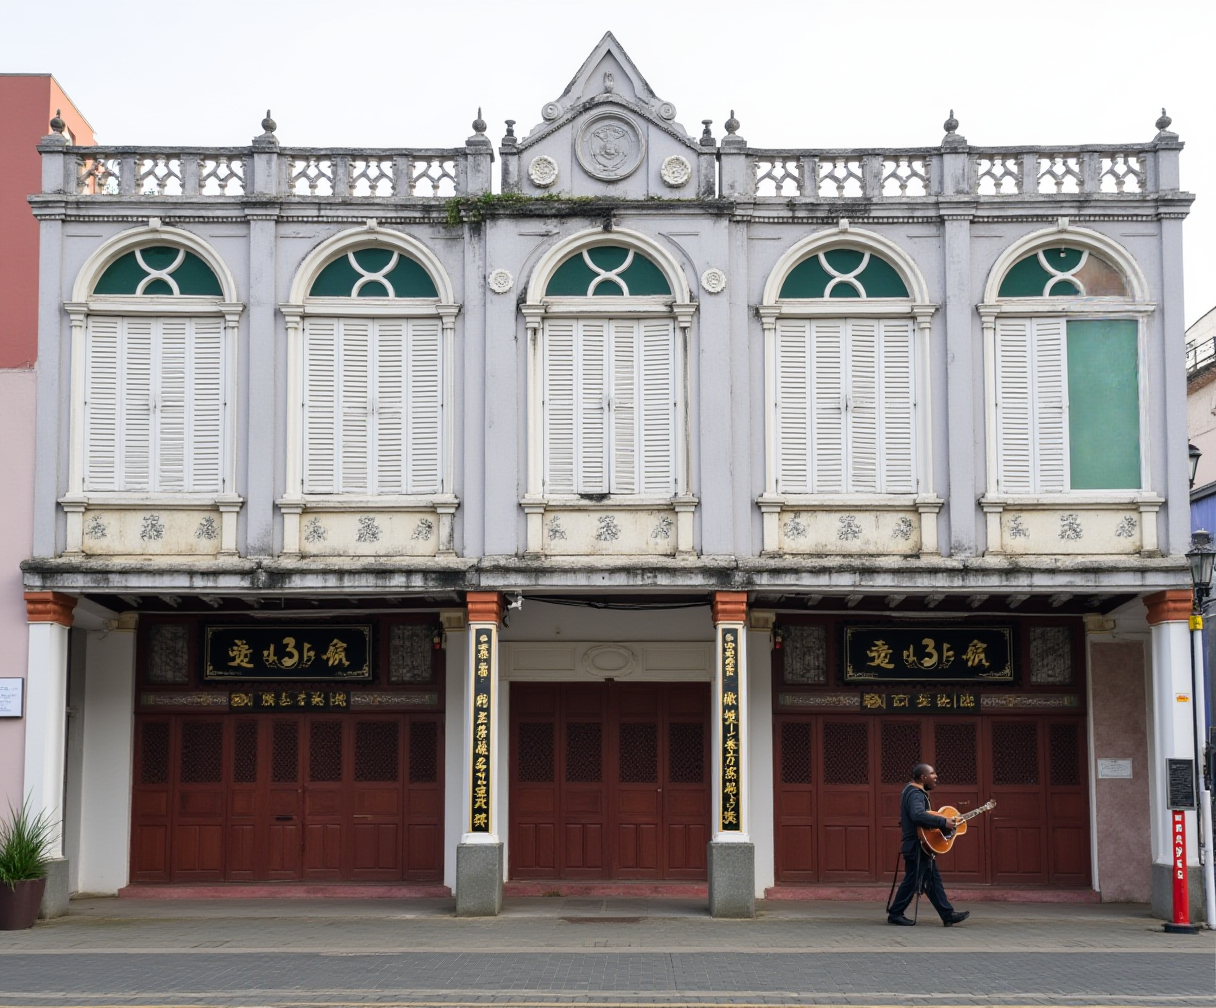

In [45]:
#seed = random.randint(0,10000)
seed = 4803
#pipe_prior_output = pipe_prior_redux(control_image)
images = pipe(
    **kwargs,
    height = control_image.height,
    width = control_image.width,
    generator=torch.Generator("cpu").manual_seed(seed),
    **pipe_prior_output,
).images
images[0]